# Загрузка библиотек

In [1]:
# pip install --user imblearn
# pip install -U threadpoolctl # для устранения AttributeError: 'NoneType' object has no attribute 'split'

In [1]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load

# Загрузка данных

In [2]:
reviews_train = []
for line in open('data//train_data.txt', 'r'):
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('data//test_data.txt', 'r'):
    reviews_test.append(line.strip())

In [3]:
# сразу сделаем предварительную очистку данных: избавимся от знаков и сделаем все буквы строчными

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

# Целевые признаки

In [4]:
# Рейтинги
rating = []
for line in open('data//rating_train.txt', 'r'):
    rating.append(line.strip())
    
rating_test = []
for line in open('data//rating_test.txt', 'r'):
    rating_test.append(line.strip())

# Подготовка

Для балансировки классов

In [5]:
nm = NearMiss()

Функция для обучения модели и вывода метрик

In [6]:
def model_fit_score(model, X, rating):
    print(model)
   
    # Разделение на трейн и валидацию
    X_train, X_val, y_train, y_val = train_test_split(X, rating, train_size = 0.8, random_state=10)
    # балансировка

    # обучение на трейн, с предвариельной балансировкой
    X_train, y_train = nm.fit_resample(X_train, y_train)
    model.fit(X_train, y_train)
    print('точность на валидационных данных: ', accuracy_score(y_val, model.predict(X_val)))
    
    # обучим на всех данных, предварительно сделав балансировку
    X, rating = nm.fit_resample(X, rating)
    model.fit(X, rating)
    print('точность на тестовых данных :', accuracy_score(rating_test, model.predict(X_test)))
    print('отчет на тестовых данных')
    print(classification_report(rating_test, model.predict(X_test), \
          target_names = ['1', '2','3', '4', '7', '8', '9', '10']))

Будем тестировать две модели:
- логистическую регрессию
- метод опорных векторов 

Обе эти модели хорошо работют с разреженными данными.

In [7]:
lr = LogisticRegression(random_state=10, solver = 'liblinear')
svc = LinearSVC()

# Поиск решения

## N-граммы

Попробуем вместо отдельных слов использовать n-граммы. А также исключим стоп-слова.

In [50]:
# вариант с ngram_range=(1, 2)
cv1 = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
# обучаем на трейн-данных
cv1.fit(reviews_train_clean)
# векторизуем трейн и тест данные
X = cv1.transform(reviews_train_clean)
X_test = cv1.transform(reviews_test_clean)

<AxesSubplot:ylabel='Count'>

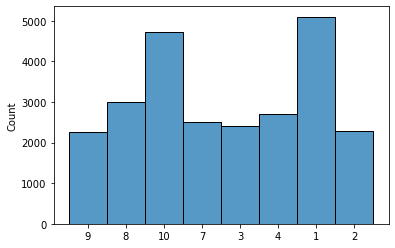

In [51]:
# для проверки
# распределение классов до балансировки
sns.histplot(rating)

<AxesSubplot:ylabel='Count'>

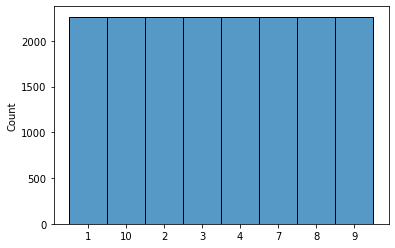

In [52]:
# сбалансируем классы
X_, rating_ = nm.fit_resample(X, rating)
# посмотрим что получилось
sns.histplot(rating_)

Кол-во классов сравнялось, уменьшив размерность доминирующего класса.

In [63]:
model_fit_score(lr, X, rating)

LogisticRegression(random_state=10, solver='liblinear')
точность на валидационных данных:  0.3426
точность на тестовых данных : 0.34616
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.62      0.49      0.55      5022
           2       0.55      0.47      0.51      4999
           3       0.20      0.27      0.23      2302
           4       0.22      0.24      0.23      2541
           7       0.28      0.26      0.27      2635
           8       0.26      0.29      0.27      2307
           9       0.24      0.20      0.22      2850
          10       0.21      0.30      0.25      2344

    accuracy                           0.35     25000
   macro avg       0.32      0.31      0.31     25000
weighted avg       0.38      0.35      0.36     25000



Понизилась точность модели по сравнению с baseline, но удалось немного повысить значения "recall" для миноритарных классов. Таким образом убрали несбалансированность классов.

In [66]:
model_fit_score(svc, X, rating)

LinearSVC()


C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


точность на валидационных данных:  0.344


C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


точность на тестовых данных : 0.3414
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.62      0.49      0.55      5022
           2       0.55      0.47      0.51      4999
           3       0.20      0.27      0.23      2302
           4       0.22      0.24      0.23      2541
           7       0.28      0.26      0.27      2635
           8       0.26      0.29      0.27      2307
           9       0.24      0.20      0.22      2850
          10       0.21      0.30      0.25      2344

    accuracy                           0.35     25000
   macro avg       0.32      0.31      0.31     25000
weighted avg       0.38      0.35      0.36     25000



In [25]:
# вариант с ngram_range=(1, 3)
cv2 = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words='english')
# обучаем на трейн-данных
cv2.fit(reviews_train_clean)
# векторизуем трейн и тест данные
X = cv2.transform(reviews_train_clean)
X_test = cv2.transform(reviews_test_clean)

In [68]:
model_fit_score(lr, X, rating)

LogisticRegression(random_state=10, solver='liblinear')
точность на валидационных данных:  0.3514
точность на тестовых данных : 0.35708
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.61      0.52      0.56      5022
           2       0.54      0.50      0.52      4999
           3       0.20      0.28      0.24      2302
           4       0.23      0.23      0.23      2541
           7       0.29      0.26      0.27      2635
           8       0.27      0.31      0.29      2307
           9       0.23      0.18      0.20      2850
          10       0.22      0.30      0.25      2344

    accuracy                           0.36     25000
   macro avg       0.32      0.32      0.32     25000
weighted avg       0.38      0.36      0.36     25000



In [69]:
model_fit_score(svc, X, rating)

LinearSVC()


C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


точность на валидационных данных:  0.3542


C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


точность на тестовых данных : 0.3574
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.61      0.52      0.56      5022
           2       0.54      0.50      0.52      4999
           3       0.20      0.28      0.24      2302
           4       0.23      0.23      0.23      2541
           7       0.29      0.26      0.27      2635
           8       0.27      0.31      0.29      2307
           9       0.23      0.18      0.20      2850
          10       0.22      0.30      0.25      2344

    accuracy                           0.36     25000
   macro avg       0.32      0.32      0.32     25000
weighted avg       0.38      0.36      0.36     25000



# TF-IDF 

Попробуем использовать TF-IDF статистику вместо слов/n-грамм.

In [8]:
tfidf_vectorizer1 = TfidfVectorizer()
# обучаем на трейн-данных
tfidf_vectorizer1.fit(reviews_train_clean)
# векторизуем трейн и тест данные
X = tfidf_vectorizer1.transform(reviews_train_clean)
X_test = tfidf_vectorizer1.transform(reviews_test_clean)

In [9]:
model_fit_score(lr, X, rating)

LogisticRegression(random_state=10, solver='liblinear')
точность на валидационных данных:  0.3344
точность на тестовых данных : 0.33672
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.58      0.46      0.51      5022
           2       0.56      0.41      0.47      4999
           3       0.18      0.34      0.24      2302
           4       0.22      0.19      0.20      2541
           7       0.31      0.28      0.30      2635
           8       0.30      0.32      0.31      2307
           9       0.26      0.17      0.21      2850
          10       0.20      0.35      0.25      2344

    accuracy                           0.34     25000
   macro avg       0.33      0.32      0.31     25000
weighted avg       0.38      0.34      0.35     25000



In [10]:
model_fit_score(svc, X, rating)

LinearSVC()


C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


точность на валидационных данных:  0.3264


C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


точность на тестовых данных : 0.32056
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.58      0.46      0.51      5022
           2       0.56      0.41      0.47      4999
           3       0.18      0.34      0.24      2302
           4       0.22      0.19      0.20      2541
           7       0.31      0.28      0.30      2635
           8       0.30      0.32      0.31      2307
           9       0.26      0.17      0.21      2850
          10       0.20      0.35      0.25      2344

    accuracy                           0.34     25000
   macro avg       0.33      0.32      0.31     25000
weighted avg       0.38      0.34      0.35     25000



In [8]:
# вариант с удалением стоп-слов
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english')
# обучаем на трейн-данных
tfidf_vectorizer2.fit(reviews_train_clean)
# векторизуем трейн и тест данные
X = tfidf_vectorizer2.transform(reviews_train_clean)
X_test = tfidf_vectorizer2.transform(reviews_test_clean)

In [9]:
model_fit_score(lr, X, rating)

LogisticRegression(random_state=10, solver='liblinear')
точность на валидационных данных:  0.3576
точность на тестовых данных : 0.34408
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.61      0.51      0.56      5022
           2       0.57      0.43      0.49      4999
           3       0.19      0.28      0.22      2302
           4       0.22      0.23      0.22      2541
           7       0.27      0.28      0.28      2635
           8       0.27      0.30      0.28      2307
           9       0.24      0.18      0.21      2850
          10       0.21      0.31      0.25      2344

    accuracy                           0.34     25000
   macro avg       0.32      0.31      0.31     25000
weighted avg       0.38      0.34      0.36     25000



In [15]:
model_fit_score(svc, X, rating)

LinearSVC()


C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


точность на валидационных данных:  0.3318


C:\Users\i_a_f\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


точность на тестовых данных : 0.31172
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.61      0.51      0.56      5022
           2       0.57      0.43      0.49      4999
           3       0.19      0.28      0.22      2302
           4       0.22      0.23      0.22      2541
           7       0.27      0.28      0.28      2635
           8       0.27      0.30      0.28      2307
           9       0.24      0.18      0.21      2850
          10       0.21      0.31      0.25      2344

    accuracy                           0.34     25000
   macro avg       0.32      0.31      0.31     25000
weighted avg       0.38      0.34      0.36     25000



# Подбор гиперпараметров

Наилучший результат на тестовых данных показала модель опорных векторов c CountVectorizer(ngram_range=(1, 3)) с удалением стоп-слов. У модели логистической регрессии с TF-IDF с удалением стоп-слов результат чуть похуже, но в качестве финальной модели выберу все-таки его, так как дамп этой модели получается гораздо более "легким" и работает гораздо шустрее. Попробуем подобрать к нему оптимальные гиперпараметры.

In [11]:
# заново подготовим данные - векторизуем трейн и тест данные
X = tfidf_vectorizer2.transform(reviews_train_clean)
X_test = tfidf_vectorizer2.transform(reviews_test_clean)

# балансировка
X, rating = nm.fit_resample(X, rating)

In [12]:
for c in [0.01, 0.1, 0.5, 1]:
    lr = LogisticRegression(random_state=10, solver = 'liblinear', C=c)
    lr.fit(X, rating)
    print(lr)
    print('точность на тестовых данных :', accuracy_score(rating_test, lr.predict(X_test)))
    print('отчет на тестовых данных')
    print(classification_report(rating_test, lr.predict(X_test), \
          target_names = ['1', '2','3', '4', '7', '8', '9', '10']))
    print()

LogisticRegression(C=0.01, random_state=10, solver='liblinear')
точность на тестовых данных : 0.32712
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.42      0.65      0.51      5022
           2       0.53      0.42      0.47      4999
           3       0.20      0.15      0.17      2302
           4       0.24      0.11      0.15      2541
           7       0.29      0.15      0.20      2635
           8       0.23      0.30      0.26      2307
           9       0.26      0.10      0.15      2850
          10       0.17      0.34      0.23      2344

    accuracy                           0.33     25000
   macro avg       0.29      0.28      0.27     25000
weighted avg       0.33      0.33      0.31     25000


LogisticRegression(C=0.1, random_state=10, solver='liblinear')
точность на тестовых данных : 0.34656
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.51      0.58      0

Наилучшее качество при С=0.5

# Финальная модель

In [15]:
# финальная модель с оптимальными параметрами
final_model =LogisticRegression(random_state=10, solver = 'liblinear', C=0.5)
# обучим на всех данных
final_model.fit(X, rating)
print('точность на тестовых данных :', accuracy_score(rating_test, final_model.predict(X_test)))
print('отчет на тестовых данных')
print(classification_report(rating_test, final_model.predict(X_test), \
      target_names = ['1', '2','3', '4', '7', '8', '9', '10']))

точность на тестовых данных : 0.35028
отчет на тестовых данных
              precision    recall  f1-score   support

           1       0.59      0.52      0.56      5022
           2       0.57      0.45      0.50      4999
           3       0.19      0.28      0.23      2302
           4       0.22      0.22      0.22      2541
           7       0.29      0.28      0.28      2635
           8       0.27      0.31      0.29      2307
           9       0.25      0.17      0.20      2850
          10       0.20      0.32      0.25      2344

    accuracy                           0.35     25000
   macro avg       0.32      0.32      0.32     25000
weighted avg       0.38      0.35      0.36     25000



In [16]:
# сохранение моделей
dump(tfidf_vectorizer2, './saved_models/vectorizer_rating.joblib')
dump(final_model, './saved_models/model_rating.joblib')

['./saved_models/model_rating.joblib']

# Тестирование

In [3]:
tfidf_vectorizer = load('./saved_models/vectorizer_rating.joblib')
model_rating = load('./saved_models/model_rating.joblib')

In [6]:
test1 = ['The movie is awesome! Hooked, the second day I think about it. \
        Real life with its unexpected twists and turns. Excellent acting.\
        To say an interesting, intriguing story is to say nothing. \
        I havent seen such deep character development in a long time. \
        I highly recommend watching the movie!']
test1 = tfidf_vectorizer.transform(test1)
model_rating.predict(test1)[0]

'10'

In [7]:
test2= ['Its just a nightmare. The movie is so crazy! The main characters are incredibly vile. \
        The plot is terrible. I was disgusted to watch. Whats the point, whats the moral']
test2 = tfidf_vectorizer.transform(test2)
model_rating.predict(test2)[0]

'2'